## Setup

In [28]:
%pip install ipympl
%pip install python-dotenv
%pip install wandb

Note: you may need to restart the kernel to use updated packages.
  Using cached python_dotenv-1.1.0-py3-none-any.whl.metadata (24 kB)
Using cached python_dotenv-1.1.0-py3-none-any.whl (20 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
#import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import random
import wandb

## Data

In [56]:
dataset_path = '/exchange/dspro2/silent-speech/full-dataset/'
# Full dataset
X = np.load(dataset_path + "X_landmarks.npy")
y = np.load(dataset_path + "y_labels.npy") #['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R''S' 'Space' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h'
 #'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 'u' 'v' 'w' 'x' 'y' 'z']

# Split data for comparison with other models
X_train = np.load(dataset_path + "X_train.npy")
X_val = np.load(dataset_path + "X_val.npy")
X_test = np.load(dataset_path + "X_test.npy")
y_train = np.load(dataset_path + "y_train.npy")
y_val = np.load(dataset_path + "y_val.npy")
y_test = np.load(dataset_path + "y_test.npy")

y = np.array([label.upper() for label in y])
print(f'X shape: {X.shape}')
print(f'X_train shape {X_train.shape}')
print(f'X_validation shape {X_val.shape}')
print(f'X_test shape {X_test.shape}')
assert ((X_train.shape[0] + X_val.shape[0] + X_test.shape[0]) == X.shape[0]), "Mismatch between X length and X splits length"

print(f'y[0] {y[0]}, y shape {y.shape}')
print(f'y_train shape {y_train.shape}')
print(f'y_val {y_val.shape}')
print(f'y_test {y_test.shape}')
assert ((y_train.shape[0]+ y_val.shape[0] + y_test.shape[0]) == y.shape[0]), "Mismatch between X length and X splits length"

X shape: (147590, 63)
X_train shape (103313, 63)
X_validation shape (22138, 63)
X_test shape (22139, 63)
y[0] A, y shape (147590,)
y_train shape (103313,)
y_val (22138,)
y_test (22139,)


### Visualize data

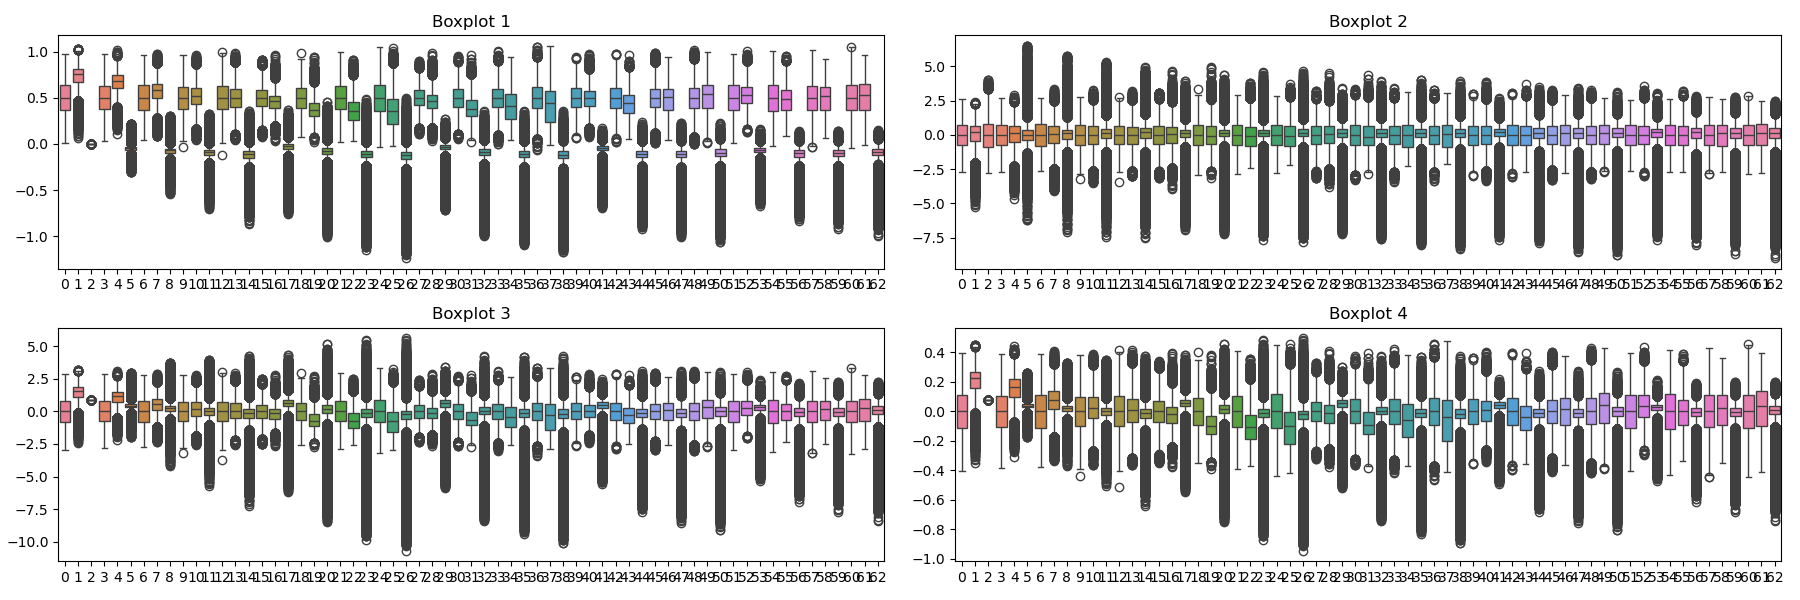

In [58]:
import seaborn as sns

# Normalize the landmarks (Standardization: mean=0, std=1)
scaler = StandardScaler()
X_train_norm1 = scaler.fit_transform(X_train)  # No reshape needed
X_val_norm1 = scaler.transform(X_val)
X_test_norm1 = scaler.transform(X_test)

# Reshape to (n_samples * 21 poses, 3 coordinates)
X_reshaped = X_train.reshape(-1, 3)
# Fit scaler on all x/y/z coordinates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)
# Reshape back to original (n_samples, 63) format
X_train_norm2 = X_scaled.reshape(X_train.shape)



# To normalize from different distances
# Reshape to (n_samples * 21 poses, 3 coordinates)
X_reshaped = X_train.reshape(-1, 3)
# Center to origin
centered = X_reshaped - X_reshaped.mean(axis=0)
# Scale to unit sphere
max_distance = np.max(np.linalg.norm(centered, axis=1))
X_normalized = centered / max_distance
# Reshape back
X_train_norm3 = X_normalized.reshape(X_train.shape)




# Set up the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(18, 6))  # 2 rows, 2 columns, size 18x6 for the entire figure

# Plotting for each subplot (example with boxplots)
sns.boxplot(data=X_train, ax=axes[0, 0])  # Top-left subplot
axes[0, 0].set_title('Boxplot 1')

sns.boxplot(data=X_train_norm1, ax=axes[0, 1])  # Top-right subplot
axes[0, 1].set_title('Boxplot 2')

sns.boxplot(data=X_train_norm2, ax=axes[1, 0])  # Bottom-left subplot
axes[1, 0].set_title('Boxplot 3')

sns.boxplot(data=X_train_norm3, ax=axes[1, 1])  # Bottom-right subplot
axes[1, 1].set_title('Boxplot 4')

# Adjust the layout to avoid overlap
plt.tight_layout()

# Show the figure
plt.show()


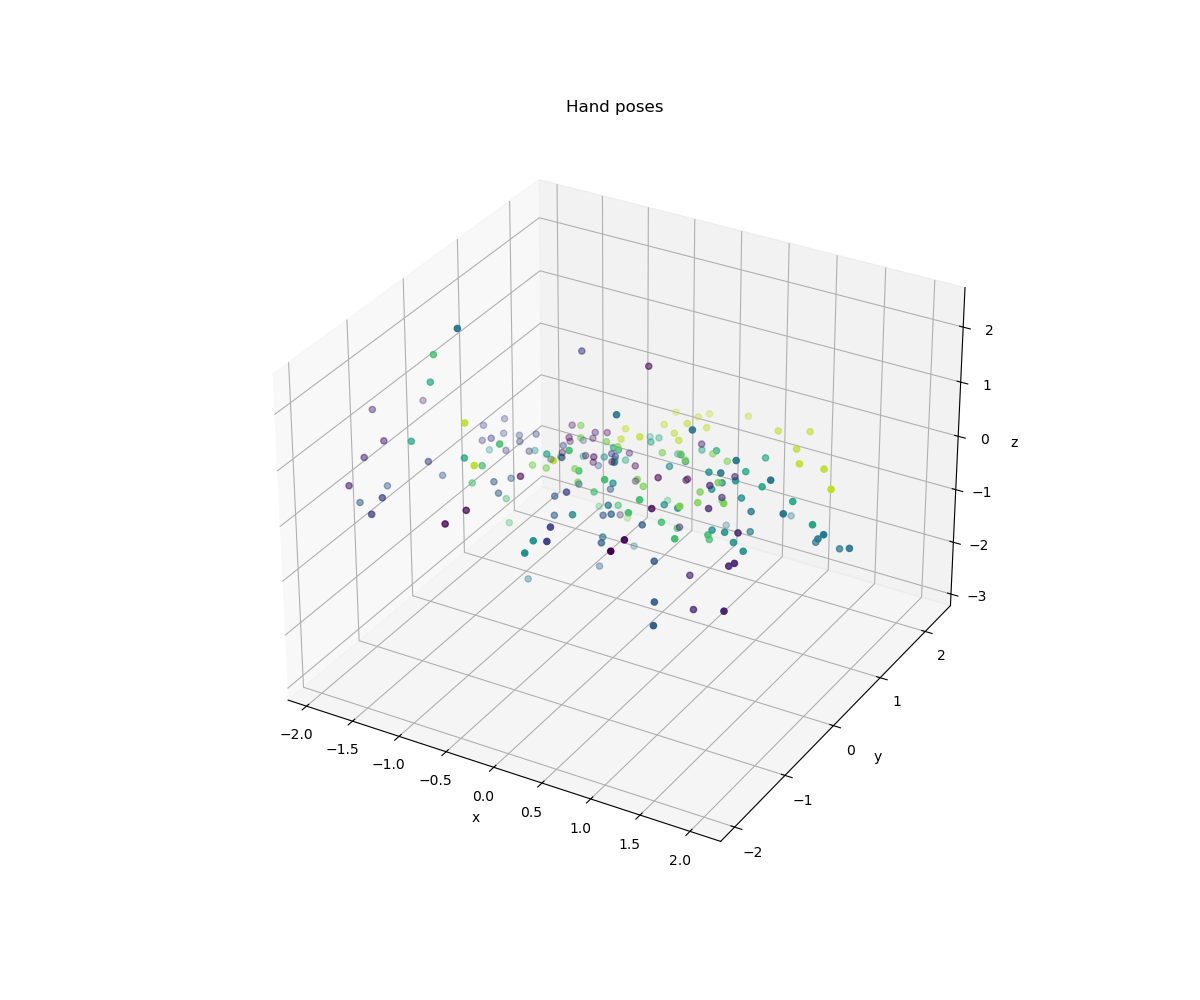

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm # Color map
# 63 hand poses, 21 points/pose, 3 coordinates per point
X_train_samples = X_train[:10]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
n = 111

# Color Map
cmap = plt.get_cmap()

for index, pose in enumerate(X_train_samples):
    # Reshape in 21x3
    points = pose.reshape(-1,3)
    x, y, z = points[:, 0], points[:,1], points[:,2]
    color = cmap(index / len(X_train_samples)) # NOrmalize index to [0,1]
    ax.scatter(x,y,z, marker='o', color=color)
    #for i in range(len(x)-1):
    #    ax.plot([x[i], x[i+1]], 
    #            [y[i], y[i+1]],
    #            [z[i], z[i+1]], color=color)
    
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Hand poses')
plt.show()

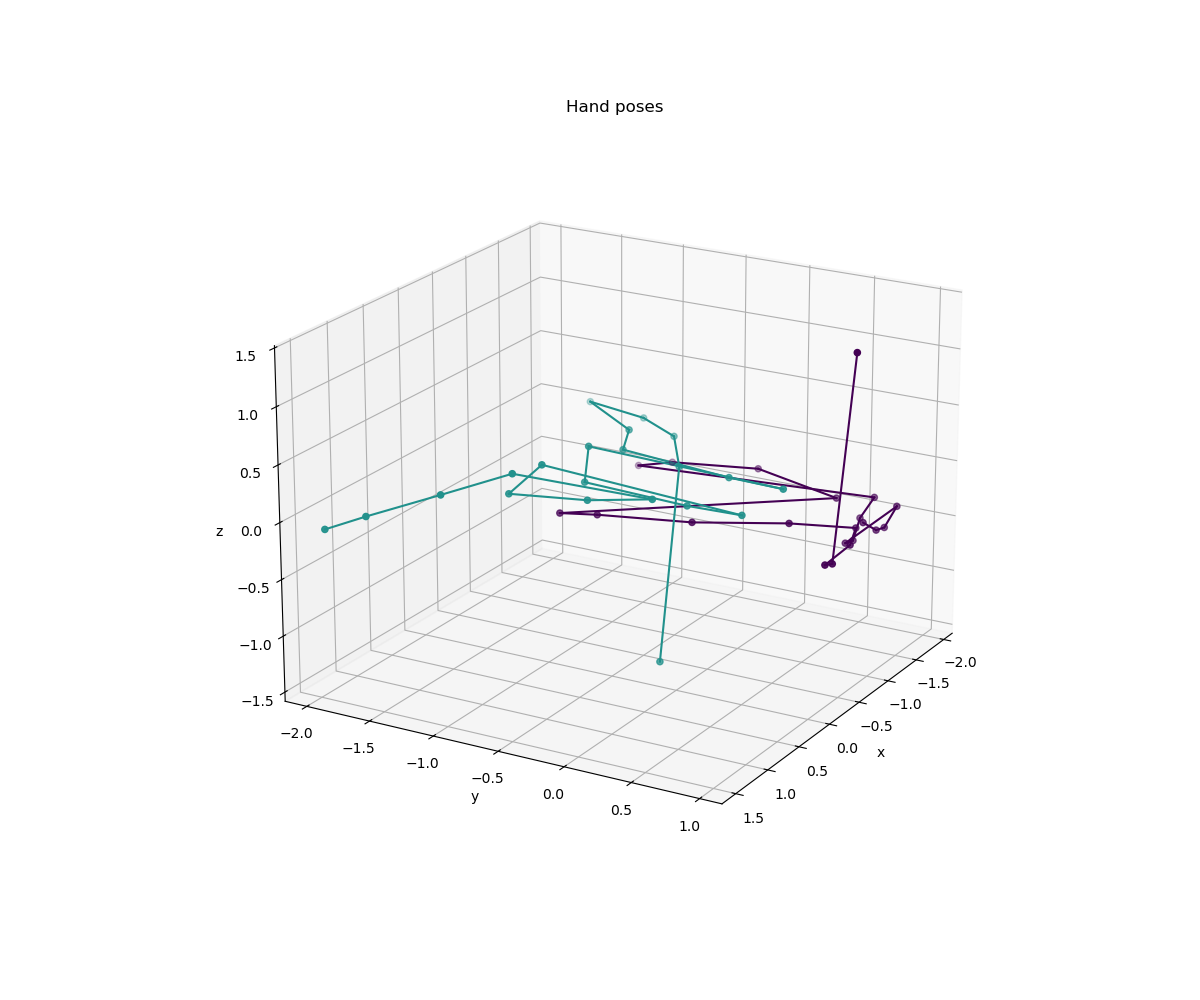

In [5]:
%matplotlib ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm # Color map
# 63 hand poses, 21 points/pose, 3 coordinates per point
X_train_samples = X_train[2:4]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
n = 111

# Color Map
cmap = plt.get_cmap()

for index, pose in enumerate(X_train_samples):
    # Reshape in 21x3
    points = pose.reshape(-1,3)
    x, y, z = points[:, 0], points[:,1], points[:,2]
    color = cmap(index / len(X_train_samples)) # Normalize index to [0,1]
    ax.scatter(x,y,z, marker='o', color=color)
    for i in range(len(x)-1):
        ax.plot([x[i], x[i+1]], 
                [y[i], y[i+1]],
                [z[i], z[i+1]], color=color, linestyle='-')
    
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Hand poses')

ax.view_init(elev=20, azim=30)
plt.show()

## Data transformation into tensors

In [25]:
device = torch.device("cuda")
# Transform into tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

## CNN Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class AslCNN(nn.Module):
    def __init__(self, num_classes):
        super(AslCNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=3, padding=1) # padding=1
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1) # padding=1
        self.fc1 = nn.Linear(32 * 21, 128) #(32 * 17, 128)  # Adjusted fully connected layer
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = x.squeeze(1)
        x = x.permute(0, 2, 1)  # Reshape from (batch, 21, 3) → (batch, 3, 21)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [7]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Data loading

In [31]:
from torch.utils.data import TensorDataset, DataLoader
# Create DataLoaders
X_train_tensor = X_train_tensor.view(-1, 1, 21, 3)  # Adjust this based on expected shape (4D and not 2D)
X_val_tensor = X_val_tensor.view(-1, 1, 21, 3)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f'X_train_tensor shape: {X_train_tensor.shape}')

X_train_tensor shape: torch.Size([103313, 1, 21, 3])


## Training, validation, test loops

In [13]:
"""import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, confusion_matrix

# Define Model, Loss, and Optimizer
num_classes = len(torch.unique(y_train_tensor)) # 27
model = AslCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Save metrics for accuracy
train_predictions = []
train_labels = []
train_loss = []

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in train_loader: 
        optimizer.zero_grad()
        outputs = model(X_batch) # goes in the AslCNN
        
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_loss.append(total_loss/len(train_loader))
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

print("Training complete!")"""

'import torch.optim as optim\nfrom sklearn.metrics import precision_score, recall_score, confusion_matrix\n\n# Define Model, Loss, and Optimizer\nnum_classes = len(torch.unique(y_train_tensor)) # 27\nmodel = AslCNN(num_classes).to(device)\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.parameters(), lr=0.001)\n\n# Save metrics for accuracy\ntrain_predictions = []\ntrain_labels = []\ntrain_loss = []\n\n# Training Loop\nnum_epochs = 10\nfor epoch in range(num_epochs):\n    model.train()\n    total_loss = 0\n    \n    for X_batch, y_batch in train_loader: \n        optimizer.zero_grad()\n        outputs = model(X_batch) # goes in the AslCNN\n        \n        loss = criterion(outputs, y_batch)\n        loss.backward()\n        optimizer.step()\n        total_loss += loss.item()\n        train_loss.append(total_loss/len(train_loader))\n    \n    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")\n\nprint("Training complete!")'

In [26]:
import datetime
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import wandb 


# Function to train the model
def train(model, train_loader, criterion, optimizer):
    device = torch.device("cuda")
    model.train()
    total_loss = 0
    batch_losses = []

    # Metrics for accuracy per epoch
    train_predictions = []
    train_labels = []

    
    for X_batch, y_batch in train_loader: 
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Reset gradient
        optimizer.zero_grad()
        
        #Raw outputs from the model
        # Forward pass automatically called by Pytorch
        outputs = model(X_batch)  
        # Loss from outputs        
        loss = criterion(outputs, y_batch) 

        #Backward pass
        loss.backward()  # Backpropagate gradients
        optimizer.step()  # Update model parameters

        #End of training loop
        
        # Log metrics
        total_loss += loss.item()  # Accumulate total loss
        #batch_losses.append(loss.item())  # Store individual batch losses
        
        # Convert outputs to predicted labels (highest logit for each sample)
    # TODO put it before the backprop
        _, predicted = torch.max(outputs, 1)  # Get predicted labels (indices of max logits)

        train_predictions.append(predicted)
        train_labels.append(y_batch)

    # Calculate the average loss for the epoch
    epoch_avg_loss = total_loss / len(train_loader)
    return epoch_avg_loss, train_predictions, train_labels


# Function to validate the model
def validate(model, val_loader, criterion):
    device = torch.device("cuda")
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    val_predictions = []
    val_labels = []
    
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            outputs = model(X_val_batch)
            loss = criterion(outputs, y_val_batch)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_val_batch).sum().item()
            total += y_val_batch.size(0)
            
            # Move tensors to CPU before appending
            val_predictions.append(predicted.cpu())  
            val_labels.append(y_val_batch.cpu())  

    # Convert tensors to numpy arrays after moving to CPU
    val_predictions = torch.cat(val_predictions).cpu().numpy()
    val_labels = torch.cat(val_labels).cpu().numpy()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total  # Calculate accuracy

    # Calculate precision, recall
    precision = precision_score(val_labels, val_predictions, average='weighted', zero_division=0)
    recall = recall_score(val_labels, val_predictions, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(val_labels, val_predictions)

    # Calculate specificity (for binary classification)
    if conf_matrix.shape == (2, 2):
        specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
    else:
        specificity = 0  # Not applicable for multi-class
    
    sensitivity = recall  # Equivalent to recall for binary classification

    return avg_val_loss, val_accuracy, precision, recall, specificity, sensitivity



# Main training and validation loop
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda")
    current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    # Save metrics for accuracy per epoch
    epoch_losses = []  # Loss values per epoch
    best_val_accuracy = 0.0
    best_epoch = 0
    best_model_predictions = []
    best_model_labels = []

    for epoch in range(num_epochs):
        # Train the model
        train_avg_loss, train_predictions, train_labels = train(model, train_loader, criterion, optimizer)
        epoch_losses.append(train_avg_loss)
        
        # Log training loss
        wandb.log({
            "train_loss": train_avg_loss
        })
        
        print(f"Epoch {epoch+1}, Train Loss: {train_avg_loss:.4f}")

        # Validate the model
        val_avg_loss, val_accuracy, precision, recall, specificity, sensitivity = validate(model, val_loader, criterion)

        # Log validation metrics
        wandb.log({
            "epoch": epoch +1,
            "val_loss": val_avg_loss,
            "val_accuracy": val_accuracy,
            "precision": precision,
            "recall": recall,
            "specificity": specificity,
            "sensitivity": sensitivity
        })
        
        print(f"Epoch {epoch+1}, Validation Loss: {val_avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        
        # Save the model with the best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch + 1
            best_model_predictions = train_predictions.copy()
            best_model_labels = train_labels.copy()
            
            # Save the model state (best model weights)
            torch.save(model.state_dict(), f'best_model_{current_time}.pth')

    # Print training results after all epochs
    print("Training complete!")
    print(f"Best model achieved at epoch {best_epoch} with validation accuracy: {best_val_accuracy:.2f}%")
    
    return model, best_model_predictions, best_model_labels, epoch_losses



In [29]:
import wandb
# check the .env file 
from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv()

# Get and print the WANDB_API_KEY
wandb_api_key = os.getenv("WANDB_API_KEY_DSPRO02")
#print(f"WANDB_API_KEY: [{wandb_api_key[:4]}...]")
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shse13 (shse13-doe) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [32]:


# Initialize wandb logging
run_nr = 1
run = wandb.init(project="ASL_CNN", 
                 name=f"CNN_test_{run_nr}",
                 config={"Conv1d": "in=3, out=16, kernel=3, pad=1",
                         "Conv1d_2": "in=16, out=32, kernel=3, pad=1",
                         "fc1": (32*21, 128),
                         "fc2": (128, 27),
                         "activations": "ReLU",
                         "epoch": 10,
                         "batch_size": 1024,
                         "optimizer": "adam",
                         "learning_rate": 1e-3,
                         "criterion": "cross_entropy",
                         "weight_decay": 1e-4,  })

config = wandb.config

num_classes = len(torch.unique(y_train_tensor)) # 27
device = torch.device("cuda")
model = AslCNN(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay) #weight_decay = regularization
criterion = nn.CrossEntropyLoss()

# Call the train_and_validate function to train and validate the model
trained_model, best_model_predictions, best_model_labels, epoch_losses = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=config.epoch)



Epoch 1, Train Loss: 0.2754
Epoch 1, Validation Loss: 0.0343, Validation Accuracy: 99.27%
Epoch 2, Train Loss: 0.0293
Epoch 2, Validation Loss: 0.0197, Validation Accuracy: 99.57%
Epoch 3, Train Loss: 0.0198
Epoch 3, Validation Loss: 0.0130, Validation Accuracy: 99.75%
Epoch 4, Train Loss: 0.0165
Epoch 4, Validation Loss: 0.0172, Validation Accuracy: 99.64%
Epoch 5, Train Loss: 0.0130
Epoch 5, Validation Loss: 0.0135, Validation Accuracy: 99.71%
Epoch 6, Train Loss: 0.0101
Epoch 6, Validation Loss: 0.0105, Validation Accuracy: 99.74%
Epoch 7, Train Loss: 0.0091
Epoch 7, Validation Loss: 0.0100, Validation Accuracy: 99.71%
Epoch 8, Train Loss: 0.0100
Epoch 8, Validation Loss: 0.0061, Validation Accuracy: 99.85%
Epoch 9, Train Loss: 0.0082
Epoch 9, Validation Loss: 0.0072, Validation Accuracy: 99.83%
Epoch 10, Train Loss: 0.0071
Epoch 10, Validation Loss: 0.0071, Validation Accuracy: 99.84%
Training complete!
Best model achieved at epoch 8 with validation accuracy: 99.85%


In [ ]:
wandb.finish() # Except if testing after

In [15]:
X_test_tensor = X_test_tensor.view(-1, 1, 21, 3) # already done above

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")
wandb.finish()

Test Accuracy: 99.82%


## Search for data leakage

In [34]:
# Check if data leakage
from sklearn.model_selection import train_test_split
import numpy as np

# Full dataset tensors
indices = np.arange(len(X))  # Create index list
print(indices)
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Convert indices to sets for comparison
train_indices = set(train_idx)
val_indices = set(val_idx)

print("Train and Val Overlap:", train_indices.intersection(val_indices))  # Should be empty


[     0      1      2 ... 147587 147588 147589]
Train and Val Overlap: set()


In [37]:
# Attempt with shuffled y to search bias in the model - can it learn the noise?

from torch.utils.data import TensorDataset, DataLoader
y_shuffled = y_train_tensor[torch.randperm(y_train_tensor.size(0))]  # Shuffle labels

if not isinstance(y_shuffled, torch.Tensor):
    y_shuffled = torch.tensor(y_shuffled, dtype=torch.long).to(device)
    
# Create a new dataset with shuffled labels
shuffled_dataset = TensorDataset(X_train_tensor, y_shuffled)

# Load into DataLoader
shuffled_loader = DataLoader(shuffled_dataset, batch_size=32, shuffle=True)

# Initialize wandb logging
run_nr = 1
run = wandb.init(project="ASL_CNN", 
                 name=f"CNN_random_leakage_search_{run_nr}",
                 config={"Conv1d": "in=3, out=16, kernel=3, pad=1",
                         "Conv1d_2": "in=16, out=32, kernel=3, pad=1",
                         "fc1": (32*21, 128),
                         "fc2": (128, 27),
                         "activations": "ReLU",
                         "epoch": 10,
                         "batch_size": 1024,
                         "optimizer": "adam",
                         "learning_rate": 1e-3,
                         "criterion": "cross_entropy",
                         "weight_decay": 1e-4,  })

config = wandb.config

num_classes = len(torch.unique(y_train_tensor)) # 27
device = torch.device("cuda")
model = AslCNN(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay) #weight_decay = regularization
criterion = nn.CrossEntropyLoss()

# Call the train_and_validate function to train and validate the model
trained_model, best_model_predictions, best_model_labels, epoch_losses = train_and_validate(
    model, shuffled_loader, val_loader, criterion, optimizer, num_epochs=config.epoch)

Epoch 1, Train Loss: 3.2822
Epoch 1, Validation Loss: 3.2843, Validation Accuracy: 3.78%
Epoch 2, Train Loss: 3.2808
Epoch 2, Validation Loss: 3.2804, Validation Accuracy: 4.22%
Epoch 3, Train Loss: 3.2807
Epoch 3, Validation Loss: 3.2810, Validation Accuracy: 3.98%
Epoch 4, Train Loss: 3.2806
Epoch 4, Validation Loss: 3.2803, Validation Accuracy: 3.78%
Epoch 5, Train Loss: 3.2805
Epoch 5, Validation Loss: 3.2809, Validation Accuracy: 3.78%
Epoch 6, Train Loss: 3.2804
Epoch 6, Validation Loss: 3.2802, Validation Accuracy: 4.03%
Epoch 7, Train Loss: 3.2803
Epoch 7, Validation Loss: 3.2805, Validation Accuracy: 3.78%
Epoch 8, Train Loss: 3.2803
Epoch 8, Validation Loss: 3.2802, Validation Accuracy: 4.03%
Epoch 9, Train Loss: 3.2803
Epoch 9, Validation Loss: 3.2808, Validation Accuracy: 4.14%
Epoch 10, Train Loss: 3.2803
Epoch 10, Validation Loss: 3.2802, Validation Accuracy: 4.10%
Training complete!
Best model achieved at epoch 2 with validation accuracy: 4.22%


In [38]:
wandb.finish()

epoch,▁▂▃▃▄▅▆▆▇█
precision,▁█▄▁▁▅▁▅▇▆
recall,▁█▄▁▁▅▁▅▇▆
sensitivity,▁█▄▁▁▅▁▅▇▆
specificity,▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▃▂▂▁▁▁▁▁
val_accuracy,▁█▄▁▁▅▁▅▇▆
val_loss,█▁▂▁▂▁▂▁▂▁
epoch,10
precision,0.00168
recall,0.04102
